# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [2]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
    print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [15]:
################## FOR TESTING PURPOSE ##################
x = np.random.randn(500, 500) + 10
p = 0.3
# print x
out, _ = dropout_forward(x, {'mode': 'train', 'p': p })
print x, out

################## FOR TESTING PURPOSE ##################

[[ 10.37233752   8.09965745  10.83110553 ...,   8.96052553   9.48514166
    9.98947545]
 [  9.74198197  10.4812022   11.0240226  ...,   9.21159463   9.43629256
   10.00520955]
 [ 10.57749027  11.26756751   9.90327326 ...,   7.95440529   9.29515067
   10.20420551]
 ..., 
 [ 10.64159526   9.25705364   9.94834393 ...,   8.60847413   9.64707249
   10.50779492]
 [  9.22589186   9.01557948   9.15496105 ...,  10.01909706  10.07407769
    8.92557878]
 [  9.68561457  10.29502236   8.91356784 ...,  11.15456072  11.05491285
   12.74377959]] [[ 10.37233752   0.          10.83110553 ...,   8.96052553   9.48514166
    0.        ]
 [  9.74198197   0.          11.0240226  ...,   9.21159463   9.43629256
    0.        ]
 [ 10.57749027   0.           9.90327326 ...,   7.95440529   9.29515067
    0.        ]
 ..., 
 [ 10.64159526   0.           9.94834393 ...,   8.60847413   9.64707249
    0.        ]
 [  9.22589186   0.           9.15496105 ...,  10.01909706  10.07407769
    0.        ]
 [  9.68561457   

In [20]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print 'Running tests with p = ', p
    print 'Mean of input: ', x.mean()
    print 'Mean of train-time output: ', out.mean()
    print 'Mean of test-time output: ', out_test.mean()
    print 'Fraction of train-time output set to zero: ', (out == 0).mean()
    print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()

Running tests with p =  0.3
Mean of input:  9.99990937105
Mean of train-time output:  7.160028794
Mean of test-time output:  9.99990937105
Fraction of train-time output set to zero:  0.284
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99990937105
Mean of train-time output:  3.79925109682
Mean of test-time output:  9.99990937105
Fraction of train-time output set to zero:  0.62
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99990937105
Mean of train-time output:  2.54167930537
Mean of test-time output:  9.99990937105
Fraction of train-time output set to zero:  0.746
Fraction of test-time output set to zero:  0.0


# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [21]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.89289328437e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [27]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print 'Running check with dropout = ', dropout
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print 'Initial loss: ', loss

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
    print

Running check with dropout =  0
Initial loss:  2.29874837282
W1 relative error: 1.62e-06
W2 relative error: 2.56e-07
W3 relative error: 6.57e-07
b1 relative error: 6.42e-09
b2 relative error: 3.74e-09
b3 relative error: 1.52e-10

Running check with dropout =  0.25
Initial loss:  2.29729655628
W1 relative error: 5.29e-06
W2 relative error: 1.57e-07
W3 relative error: 7.30e-08
b1 relative error: 7.18e-09
b2 relative error: 2.68e-09
b3 relative error: 1.63e-10

Running check with dropout =  0.5
Initial loss:  2.30268139392
W1 relative error: 1.24e-06
W2 relative error: 8.50e-06
W3 relative error: 8.50e-08
b1 relative error: 3.40e-08
b2 relative error: 1.91e-07
b3 relative error: 1.75e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [30]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print dropout

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 8.672145
(Epoch 0 / 25) train acc: 0.236000; val_acc: 0.207000
(Epoch 1 / 25) train acc: 0.340000; val_acc: 0.199000
(Epoch 2 / 25) train acc: 0.338000; val_acc: 0.211000
(Epoch 3 / 25) train acc: 0.420000; val_acc: 0.245000
(Epoch 4 / 25) train acc: 0.518000; val_acc: 0.247000
(Epoch 5 / 25) train acc: 0.608000; val_acc: 0.287000
(Epoch 6 / 25) train acc: 0.670000; val_acc: 0.260000
(Epoch 7 / 25) train acc: 0.694000; val_acc: 0.267000
(Epoch 8 / 25) train acc: 0.716000; val_acc: 0.294000
(Epoch 9 / 25) train acc: 0.782000; val_acc: 0.258000
(Epoch 10 / 25) train acc: 0.824000; val_acc: 0.263000
(Epoch 11 / 25) train acc: 0.854000; val_acc: 0.257000
(Epoch 12 / 25) train acc: 0.868000; val_acc: 0.309000
(Epoch 13 / 25) train acc: 0.890000; val_acc: 0.285000
(Epoch 14 / 25) train acc: 0.960000; val_acc: 0.306000
(Epoch 15 / 25) train acc: 0.906000; val_acc: 0.301000
(Epoch 16 / 25) train acc: 0.946000; val_acc: 0.295000
(Epoch 17 / 25) train acc: 0.920000; v

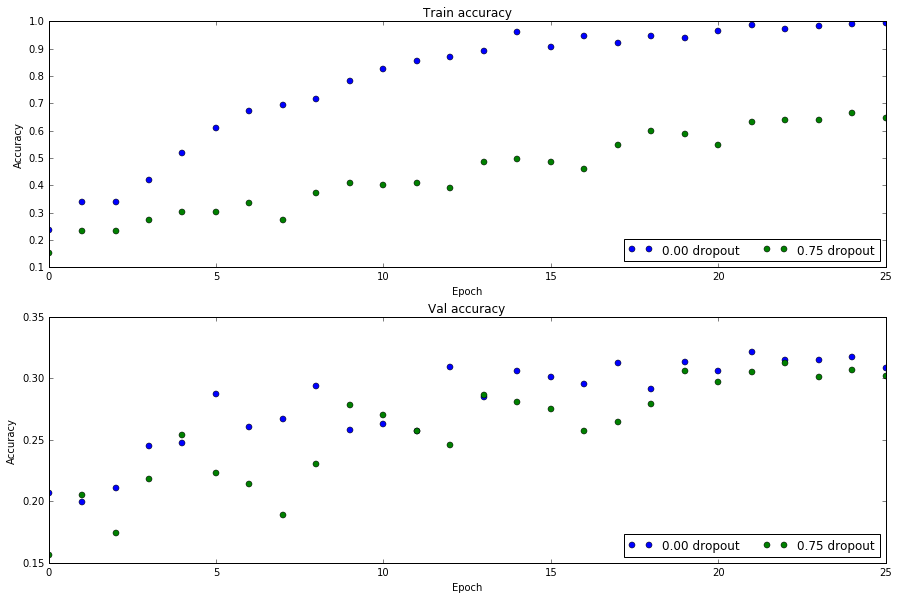

In [31]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
To prevent the model overfit. As we can see, the model with 0.00 dropout gains almost 100% accuracy on the training set but the validation set is far more lower. While in the model with 0.75 dropouts, the validation set accuracy and the training set accuracy are much closer.